In [1]:
!pip install opencv-python --trusted-host mirrors.intra.didiyun.com --index-url http://mirrors.intra.didiyun.com/pip/simple 

Looking in indexes: http://mirrors.intra.didiyun.com/pip/simple
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2,cv2

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
pycocotools not installed
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
detectron2 not installed
cv2 4.4.0


In [17]:
import torch, torchvision
import os
import numpy as np
import cv2
import random
import itertools
import pandas as pd
import shutil
from tqdm import tqdm
from urllib import request
import json
import PIL.Image as Image

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [6]:
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook
import os

In [7]:
k12ai_set_notebook(cellw=95)

In [8]:
dataset = 'faces'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, "imgs")

faces_df = pd.read_json(os.path.join(data_root, 'face_detection.json'), lines=True)
faces_df.head()

content  \
0  http://com.dataturks.a96-i23.open.s3.amazonaws...   
1  http://com.dataturks.a96-i23.open.s3.amazonaws...   
2  http://com.dataturks.a96-i23.open.s3.amazonaws...   
3  http://com.dataturks.a96-i23.open.s3.amazonaws...   
4  http://com.dataturks.a96-i23.open.s3.amazonaws...   

                                          annotation  extras  
0  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
1  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
2  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
3  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
4  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN

In [9]:
faces_df[:1]['content'].values[0]

'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg'

In [10]:
faces_df[:1]['annotation'].values[0]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384601, 'y': 0.306306306306306},
   {'x': 0.17230769230769202, 'y': 0.45345345345345306}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.291291291291291},
   {'x': 0.6584615384615381, 'y': 0.468468468468468}],
  'imageWidth': 650,
  'imageHeight': 333}]

## Data Preprocessing

下载速度慢: 修改/etc/hosts `52.216.241.132 com.dataturks.a96-i23.open.s3.amazonaws.com`

In [11]:
os.makedirs(imgs_path, exist_ok=True)

dataset = []

for index, row in tqdm(faces_df.iterrows(), total=faces_df.shape[0]):
    image_name = f'face_{index}.jpeg'
    image_path = f'{imgs_path}/{image_name}'
    if not os.path.exists(image_path):
        print(image_path, row["content"])
        try:
            img = request.urlopen(row["content"], timeout=3)
            img = Image.open(img)
        except:
            print('timeout:', row["content"], image_path)
            continue
        img = img.convert('RGB')
        img.save(image_path, "JPEG")
    else:
        pass
    
    annotations = row['annotation']
    for an in annotations:
        data = {}
        width = an['imageWidth']
        height = an['imageHeight']
        points = an['points']

        data['file_name'] = image_name
        data['width'] = width
        data['height'] = height

        data["x_min"] = int(round(points[0]["x"] * width))
        data["y_min"] = int(round(points[0]["y"] * height))
        data["x_max"] = int(round(points[1]["x"] * width))
        data["y_max"] = int(round(points[1]["y"] * height))

        data['class_name'] = 'face'
        dataset.append(data)
dataset[:2]

100%|██████████| 409/409 [00:00<00:00, 3275.59it/s]


[{'file_name': 'face_0.jpeg',
  'width': 650,
  'height': 333,
  'x_min': 56,
  'y_min': 102,
  'x_max': 112,
  'y_max': 151,
  'class_name': 'face'},
 {'file_name': 'face_0.jpeg',
  'width': 650,
  'height': 333,
  'x_min': 379,
  'y_min': 97,
  'x_max': 428,
  'y_max': 156,
  'class_name': 'face'}]

In [12]:
df = pd.DataFrame(dataset)
df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
0  face_0.jpeg    650     333     56    102    112    151       face
1  face_0.jpeg    650     333    379     97    428    156       face
2  face_1.jpeg   1280     697    903    162    985    252       face
3  face_2.jpeg    460     240    216     12    279     80       face
4  face_2.jpeg    460     240    289      2    343     74       face

In [13]:
'images:', df.file_name.unique().shape[0], 'face boxes:', df.shape[0]

('images:', 409, 'face boxes:', 1132)

In [11]:
df.to_csv(os.path.join(data_root, 'annotations.csv'), header=True, index=None)

## Yolov5 Data

In [14]:
# for yolo
os.system(f'mkdir -p {data_root}/yolo/images')
os.system(f'mkdir -p {data_root}/yolo/labels')

name2label = {
    'face': 0
}

def yolo_convert(d):
    dw, dh = 1.0 / d.width, 1.0 / d.height
    bw, bh = (d.x_max - d.x_min), (d.y_max - d.y_min)
    cx, cy = (d.x_min + d.x_max) / 2.0 - 1, (d.y_min + d.y_max) / 2.0 - 1
    d['x_center_norm'] = cx * dw
    d['y_center_norm'] = cy * dh
    d['b_width_norm']  = bw * dw
    d['b_height_norm'] = bh * dh
    return d

yolo_df = df.apply(yolo_convert, axis=1)

In [15]:
yolo_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name  \
0  face_0.jpeg    650     333     56    102    112    151       face   
1  face_0.jpeg    650     333    379     97    428    156       face   
2  face_1.jpeg   1280     697    903    162    985    252       face   
3  face_2.jpeg    460     240    216     12    279     80       face   
4  face_2.jpeg    460     240    289      2    343     74       face   

   x_center_norm  y_center_norm  b_width_norm  b_height_norm  
0       0.127692       0.376877      0.086154       0.147147  
1       0.619231       0.376877      0.075385       0.177177  
2       0.736719       0.295552      0.064063       0.129125  
3       0.535870       0.187500      0.136957       0.283333  
4       0.684783       0.154167      0.117391       0.300000

In [18]:
def gen_yolo_file(df):
    for i, row in df.iterrows():
        # train
        raw_file = os.path.join(imgs_path, row.file_name)
        img_yolo = os.path.join(data_root, 'yolo/images', 'train')
        txt_yolo = os.path.join(data_root, 'yolo/labels', 'train')
        if not os.path.exists(img_yolo):
            os.makedirs(img_yolo)
            os.makedirs(txt_yolo)
        shutil.copy(raw_file, f'{img_yolo}/{row.file_name}')
        txt_name = row.file_name.split('.')[0] + '.txt' 
        txt_file = os.path.join(txt_yolo, txt_name)
        with open(txt_file, 'w') as fw:
            fw.write('0 %.6f %.6f %.6f %.6f' % (
                row.x_center_norm,
                row.y_center_norm,
                row.b_width_norm,
                row.b_height_norm
            ))
        if random.random() > 0.7:
            # val
            img_yolo = os.path.join(data_root, 'yolo/images', 'val')
            txt_yolo = os.path.join(data_root, 'yolo/labels', 'val')
            if not os.path.exists(img_yolo):
                os.mkdir(img_yolo)
                os.mkdir(txt_yolo)
            shutil.copy(raw_file, f'{img_yolo}/{row.file_name}')
            shutil.copy(txt_file, f'{txt_yolo}/{txt_name}')
    
gen_yolo_file(yolo_df) 

In [19]:
yolo_df.to_csv(os.path.join(data_root, 'yolo', 'annotations.csv'), header=True, index=None)

## Data Exploration

In [1]:
def annotate_image(annotations, resize=True):
    file_name = annotations.file_name.to_numpy()[0]
    img = cv2.cvtColor(cv2.imread(f'{imgs_path}/{file_name}'), cv2.COLOR_BGR2RGB)

    for i, a in annotations.iterrows():
        cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

    if not resize:
        return img

    return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

In [24]:
img_df = df[df.file_name == df.file_name.unique()[0]]
img_df

16

(650, 333) RGB


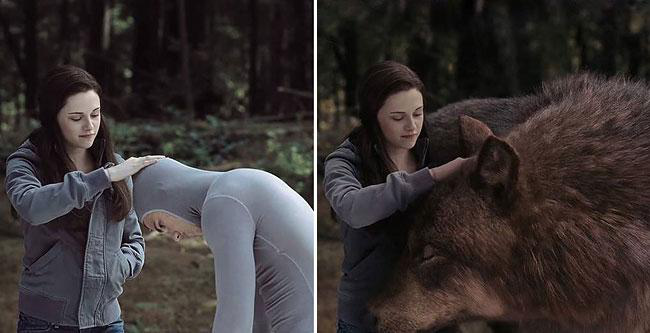

In [27]:
img = Image.open(os.path.join(imgs_path, img_df.file_name.to_numpy()[0]))
print(img.size, img.mode)
img

(333, 650, 3)


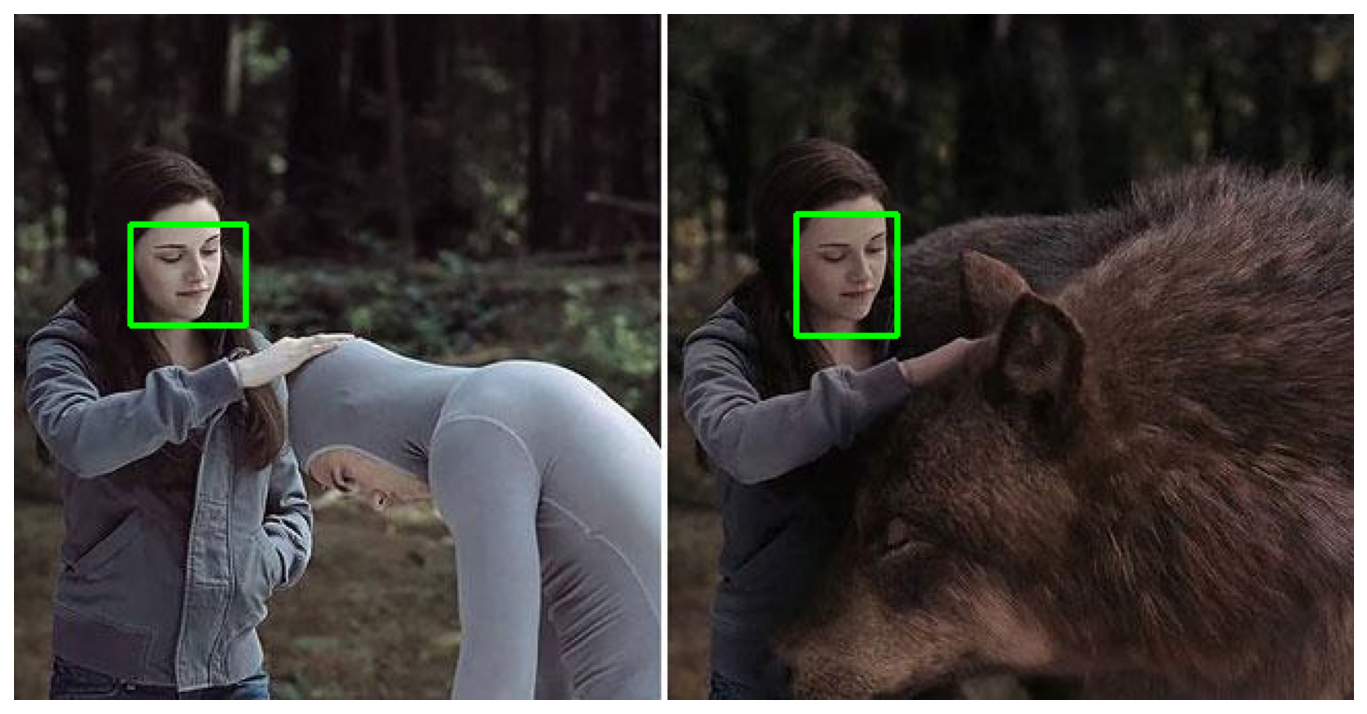

In [31]:
img = annotate_image(img_df, resize=False)
print(img.shape) # (H W C)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off');

In [15]:
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)
sample_images.shape

torch.Size([10, 384, 384, 3])

In [16]:
sample_images = sample_images.permute(0, 3, 1, 2)
sample_images.shape

torch.Size([10, 3, 384, 384])

torch.Size([3, 774, 1932])


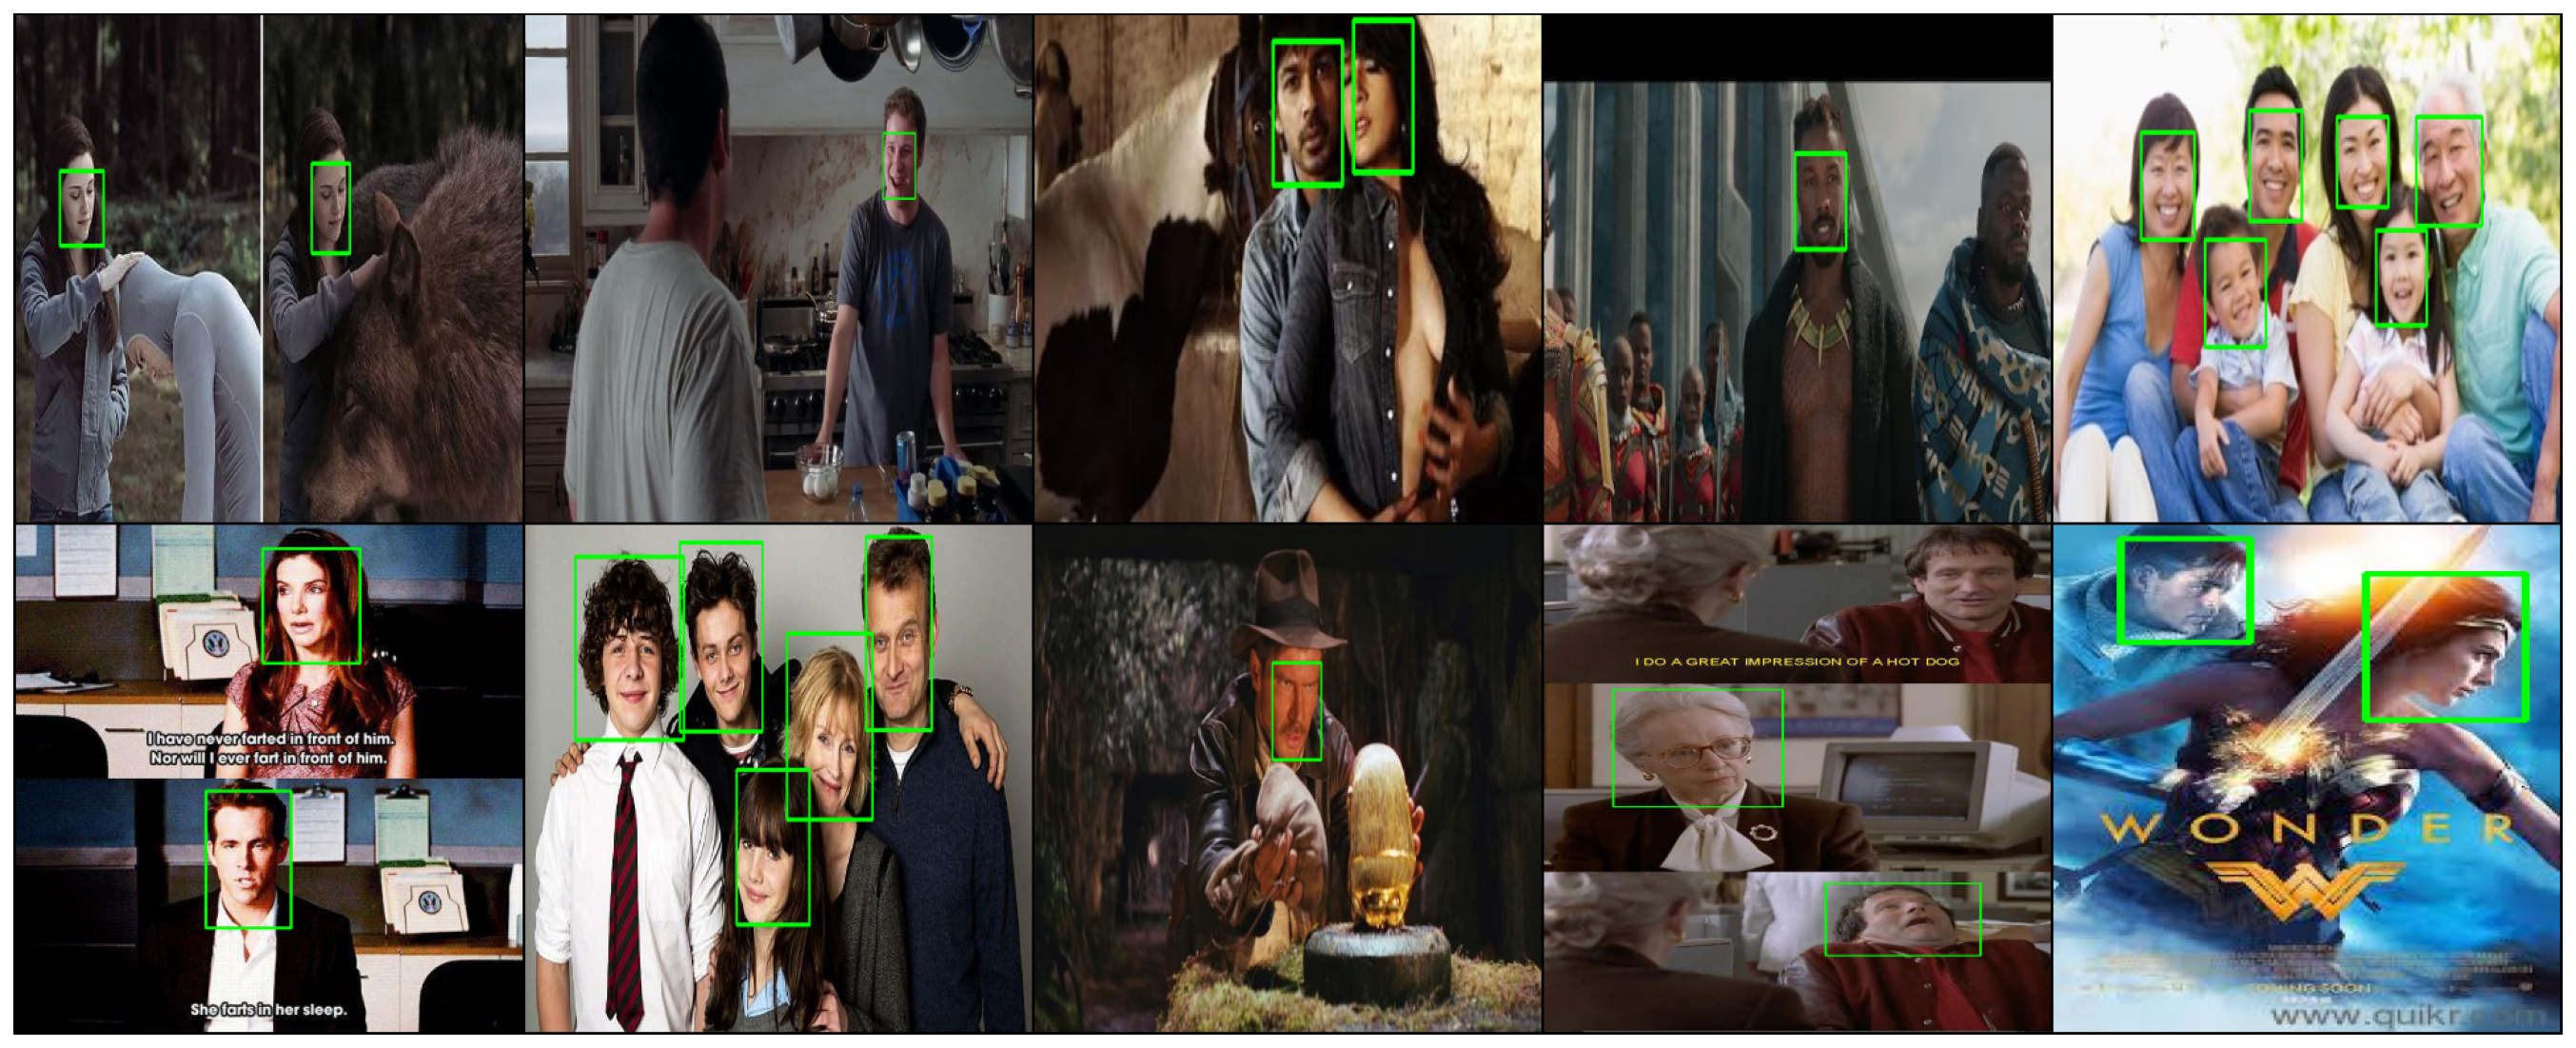

In [17]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)
print(grid_img.shape)
plt.imshow(grid_img.permute(1, 2, 0)) # to (H W C)
plt.axis('off');

## References

1. https://towardsdatascience.com/face-detection-on-custom-dataset-with-detectron2-and-pytorch-using-python-23c17e99e162